In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

import warnings
warnings.filterwarnings('ignore')

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='********',
    database='bike_store'
)
cur = db.cursor()

# 1. Sales Analysis:

## A.  What is the total sales amount (considering discounts) for each product in a given year?

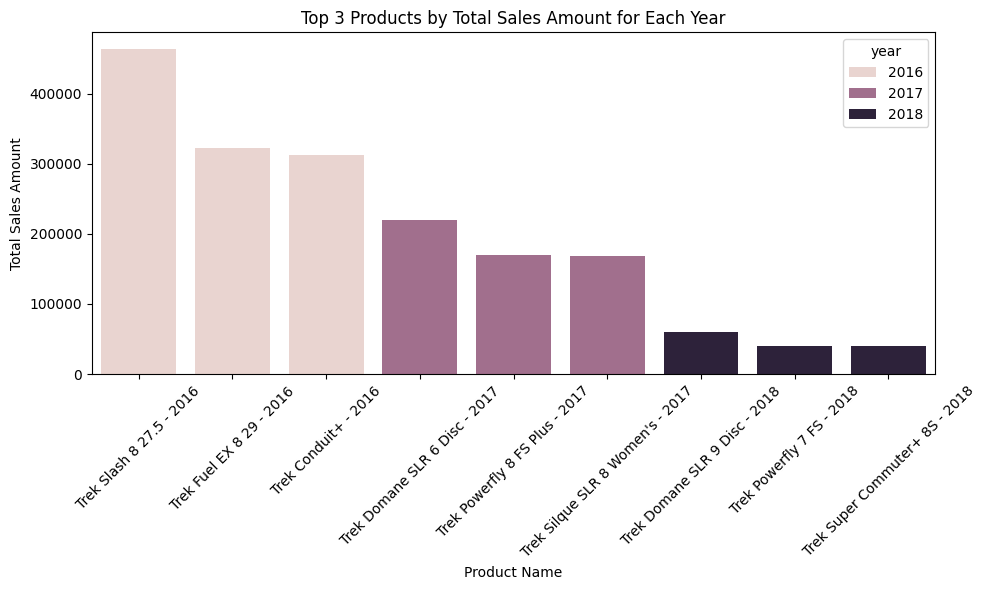

In [2]:
query = """WITH ranked_products AS (
  SELECT 
    p.product_id, p.product_name, YEAR(o.order_date) AS year,
    SUM(oi.quantity * (oi.list_price - (oi.list_price * oi.discount / 100))) AS total_sales_amount,
    ROW_NUMBER() OVER (PARTITION BY YEAR(o.order_date) ORDER BY SUM(oi.quantity * (oi.list_price - (oi.list_price * oi.discount / 100))) DESC) AS row_num
  FROM 
    Order_items oi
  JOIN 
    Products p ON oi.product_id = p.product_id
  JOIN 
    Orders o ON oi.order_id = o.order_id
  GROUP BY 
    year, p.product_id, p.product_name
)
SELECT 
  product_id, product_name, year, total_sales_amount
FROM 
  ranked_products
WHERE 
  row_num <= 3
ORDER BY 
  year, total_sales_amount DESC;"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns = ["product_id","product_name","year","total_sales_amount"])

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x="product_name", y="total_sales_amount", hue="year", data=df)
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Top 3 Products by Total Sales Amount for Each Year")
plt.xlabel("Product Name")
plt.ylabel("Total Sales Amount")

plt.tight_layout()
plt.show()

## B. Which products are the top-selling items based on quantity sold?

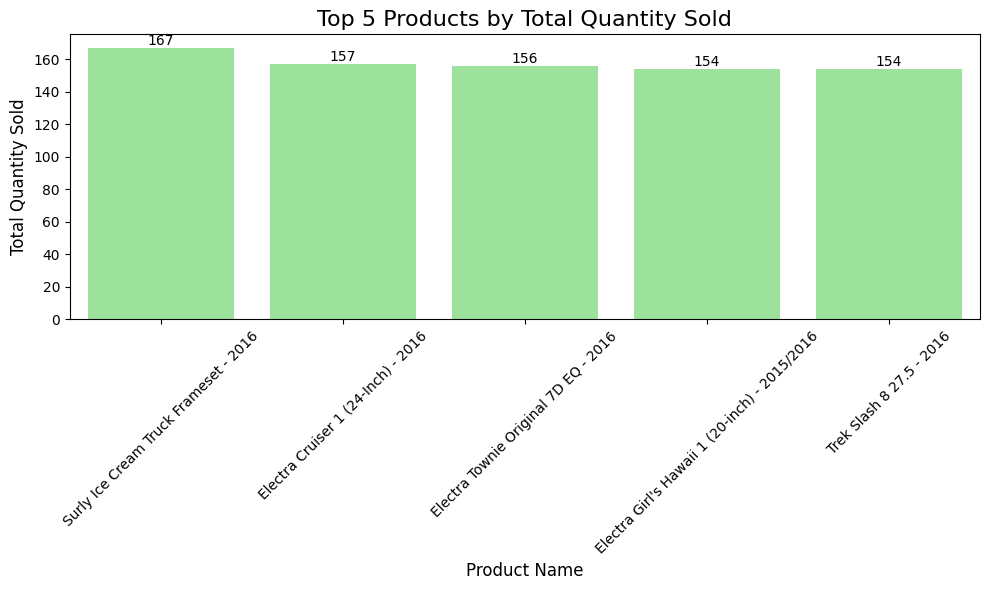

In [3]:
query = """SELECT 
    p.product_id, p.product_name, SUM(oi.quantity) total_quantity
FROM 
    order_items oi
JOIN 
    products p ON oi.product_id = p.product_id
GROUP BY 
    p.product_id, p.product_name
ORDER BY 
    total_quantity DESC
LIMIT 5"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["product_id", "product_name", "total_quantity"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="product_name", y="total_quantity", data=df, color='lightgreen')
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Top 5 Products by Total Quantity Sold", fontsize=16)
plt.xlabel("Product Name", fontsize=12)
plt.ylabel("Total Quantity Sold", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

## C. What are the monthly sales trends across different categories?

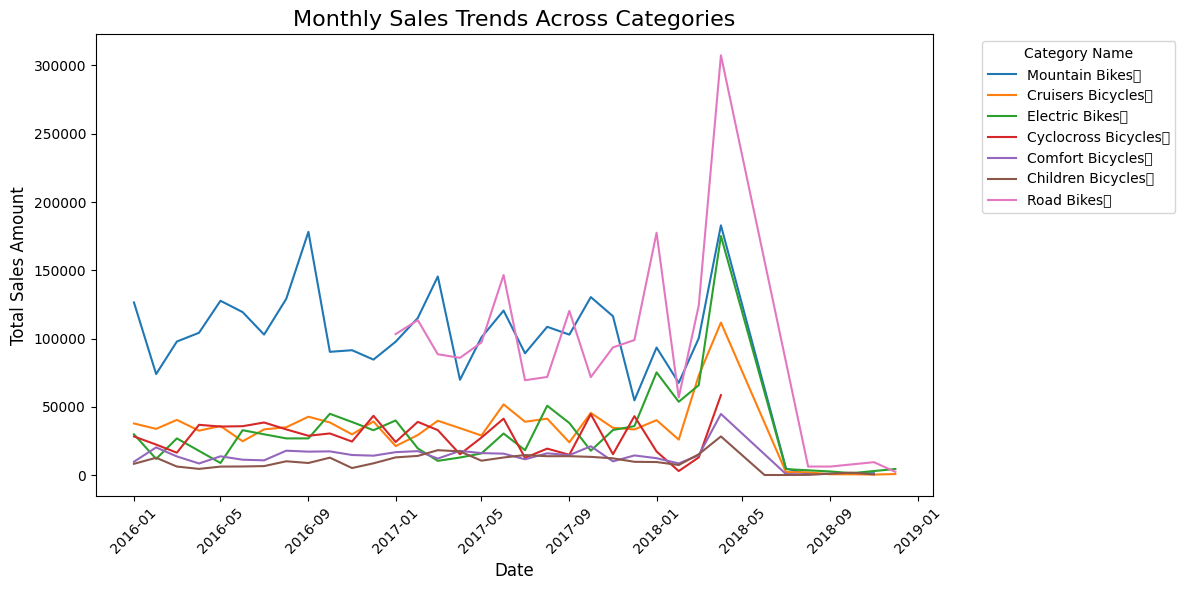

In [4]:
query = """SELECT 
	c.category_name, YEAR(o.order_date) AS year, MONTH(o.order_date) AS month,
    SUM(oi.quantity * (oi.list_price - (oi.list_price * oi.discount / 100))) AS total_sales_amount
FROM 
	Order_items oi
JOIN 
	products p ON p.product_id = oi.product_id
JOIN 
	categories c ON c.category_id = p.category_id
JOIN 
	Orders o ON oi.order_id = o.order_id
GROUP BY 
	c.category_name, year, month
ORDER BY 
	year, month, total_sales_amount DESC"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["category_name", "year", "month", "total_sales_amount"])

# Create a 'date' column from 'year' and 'month'
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='total_sales_amount', hue='category_name', ci=None)

# Add titles and labels
plt.title('Monthly Sales Trends Across Categories', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
plt.xticks(rotation=45) 
plt.legend(title='Category Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Customer Insights:

## A. How many orders were placed by each customer, and what is the total revenue generated from them?

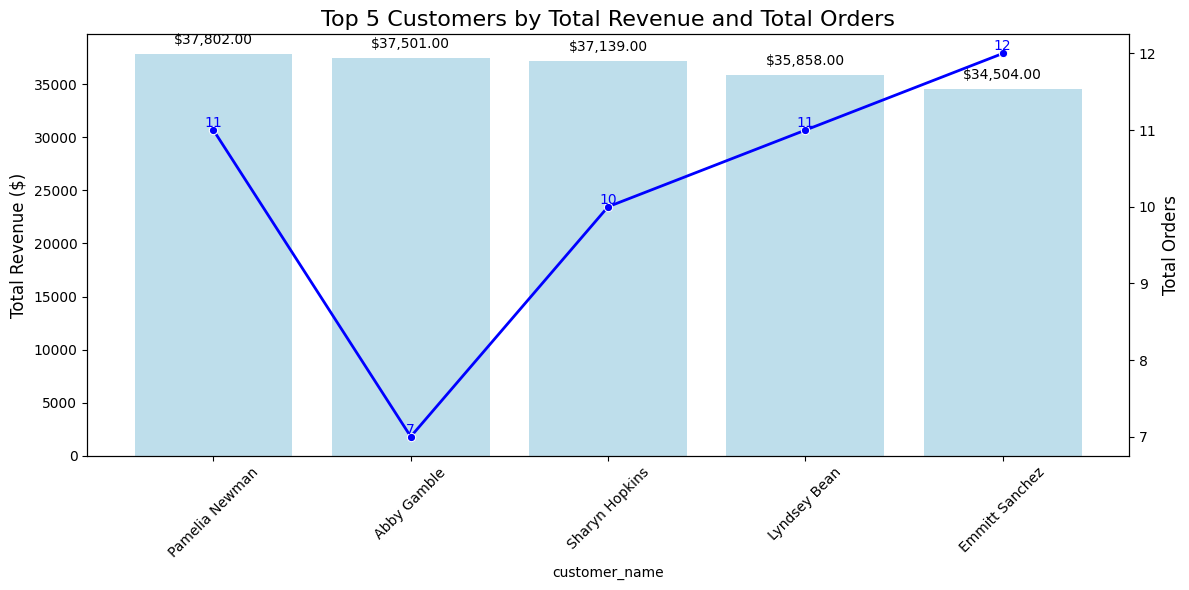

In [5]:
query = """SELECT 
    c.Customer_id, 
    CONCAT(c.first_name,' ',c.last_name) AS customer_name, 
    COUNT(o.order_id) AS total_orders,
    SUM(oi.quantity * (oi.list_price - (oi.list_price * oi.discount / 100))) AS total_revenue
FROM 
    customers c
JOIN 
    orders o ON o.customer_id = c.customer_id
JOIN 
    Order_items oi ON o.order_id = oi.order_id
GROUP BY 
    c.Customer_id, customer_name
ORDER BY 
    total_revenue DESC
LIMIT 5"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["Customer_id","customer_name", "total_orders", "total_revenue"])

# Create a bar plot for total revenue
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for total revenue
bar_plot = sns.barplot(data=df, x='customer_name', y='total_revenue', ax=ax1, color='skyblue', alpha=0.6)
ax1.set_ylabel('Total Revenue ($)', fontsize=12)
ax1.set_title('Top 5 Customers by Total Revenue and Total Orders', fontsize=16)
ax1.set_xticklabels(df['customer_name'], rotation=45)

# Add data labels to the bars
for p in bar_plot.patches:
    ax1.annotate(f'${p.get_height():,.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', 
                 fontsize=10, color='black', 
                 xytext=(0, 5), 
                 textcoords='offset points')

# Create a second y-axis for total orders
ax2 = ax1.twinx()
line_plot = sns.lineplot(data=df, x='customer_name', y='total_orders', ax=ax2, color='b', marker='o', linewidth=2)
ax2.set_ylabel('Total Orders', fontsize=12)

# Add data labels to the line plot
for i, row in df.iterrows():
    ax2.text(i, row['total_orders'], row['total_orders'], color='b', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## B. What are the top cities where most of the orders are placed?

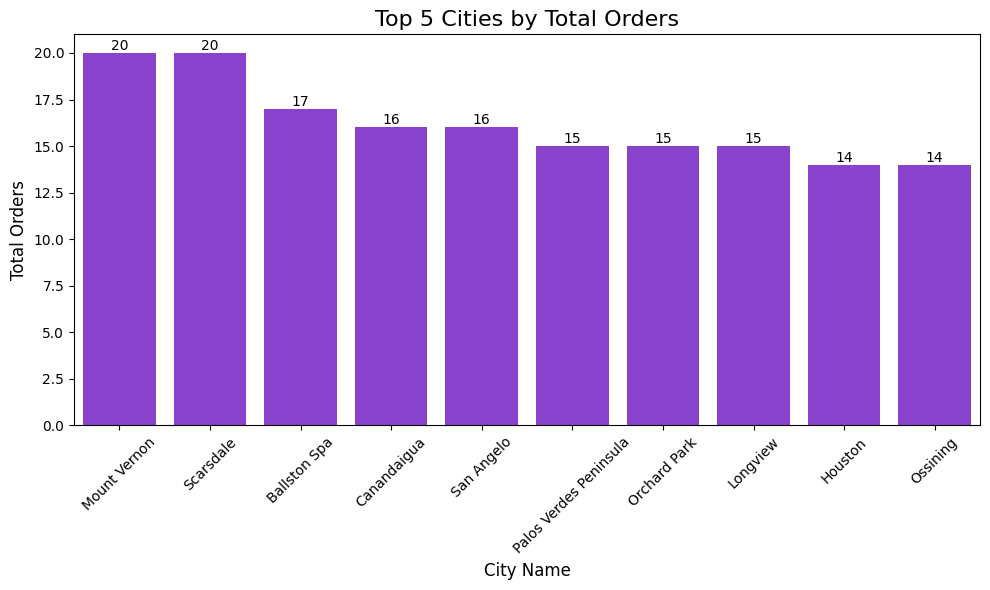

In [6]:
query = """SELECT 
	c.city, COUNT(o.order_id) AS total_orders
FROM 
	customers c
JOIN
	orders o ON o.customer_id = c.customer_id
GROUP BY
	c.city
ORDER BY
	total_orders DESC
LIMIT 10"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["city", "total_orders"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="city", y="total_orders", data=df, color='blueviolet')
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Top 5 Cities by Total Orders", fontsize=16)
plt.xlabel("City Name", fontsize=12)
plt.ylabel("Total Orders", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

## C. What are the top states where most of the orders are placed?

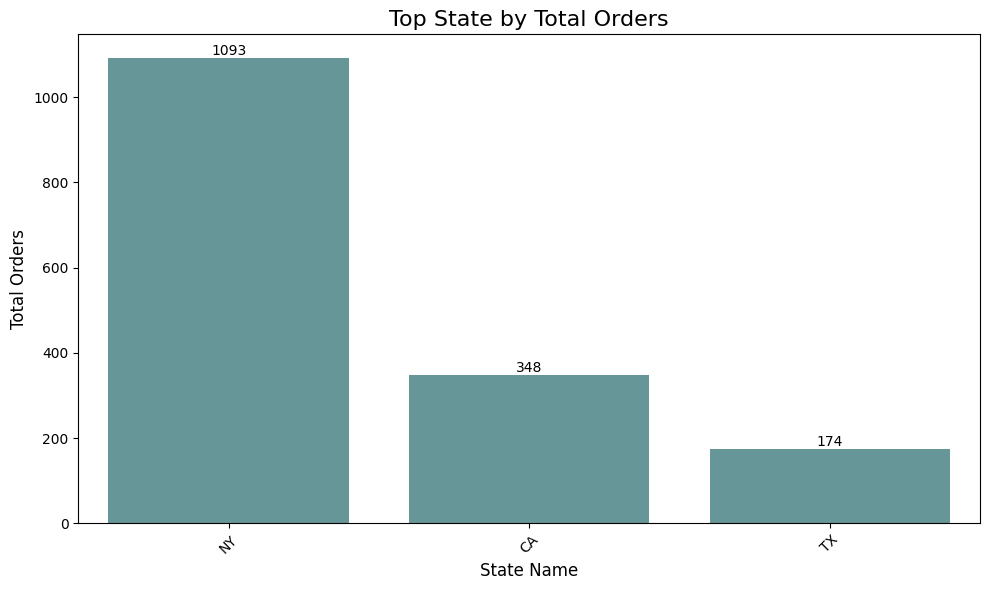

In [7]:
query = """SELECT 
	c.state, COUNT(o.order_id) AS total_orders
FROM 
	customers c
JOIN
	orders o ON o.customer_id = c.customer_id
GROUP BY
	c.state
ORDER BY
	total_orders DESC"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["state", "total_orders"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="state", y="total_orders", data=df, color='cadetblue')
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Top State by Total Orders", fontsize=16)
plt.xlabel("State Name", fontsize=12)
plt.ylabel("Total Orders", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

## D. Identify customers who haven’t placed any orders in the past year.

In [8]:
query = """SELECT 
	c.Customer_id, 
    CONCAT(c.first_name,' ',c.last_name) AS customer_name, 
    c.email,
    c.city,
    c.state
FROM 
	customers c
LEFT JOIN 
	orders o ON o.customer_id = c.customer_id
WHERE 
	YEAR(o.order_date) = 2017
GROUP BY 
	c.Customer_id, customer_name, c.email, c.city, c.state
HAVING
	COUNT(o.order_id) = 0"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["Customer_id", "customer_name","email","city","state"])

df

,Customer_id,customer_name,email,city,state


In [9]:
# The output of the query indicates that there are no customers who did not place any orders in the year 2017.

# 3. Product Performance:

## A. What are the most popular product categories by sales volume?

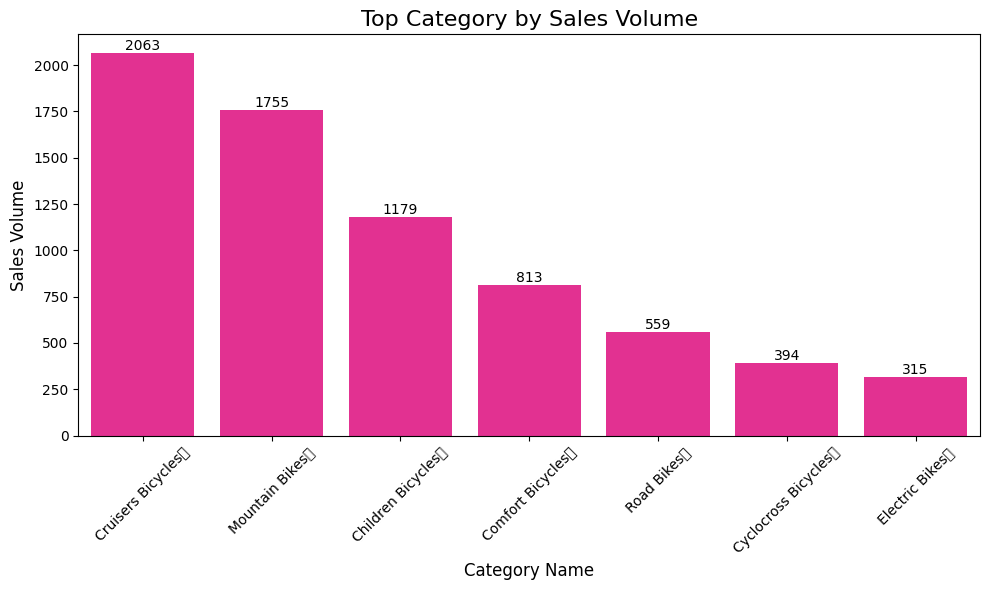

In [10]:
query = """SELECT 
	c.category_id, c.category_name, SUM(oi.quantity) as Sales_volume
FROM
	categories c
JOIN
	products p ON c.category_id = p.category_id
JOIN 
	order_items oi ON oi.product_id = p.product_id
GROUP BY
	c.category_id, c.category_name
ORDER BY
	Sales_volume DESC
"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["category_id", "category_name","Sales_volume"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="category_name", y="Sales_volume", data=df, color='deeppink')
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Top Category by Sales Volume", fontsize=16)
plt.xlabel("Category Name", fontsize=12)
plt.ylabel("Sales Volume", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

## B. What are the least popular product categories by sales volume?

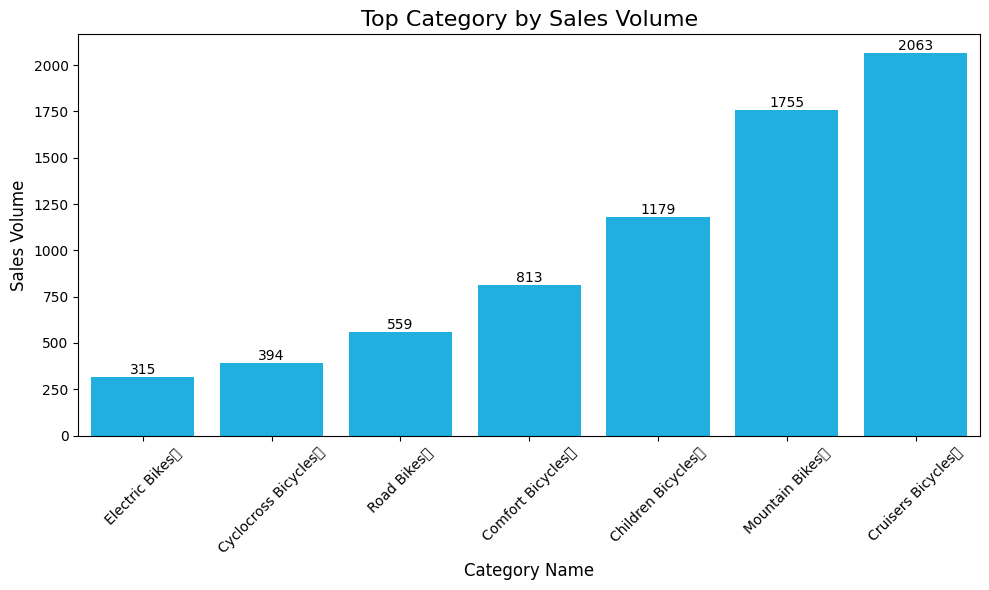

In [11]:
query = """SELECT 
	c.category_id, c.category_name, SUM(oi.quantity) as Sales_volume
FROM
	categories c
JOIN
	products p ON c.category_id = p.category_id
JOIN 
	order_items oi ON oi.product_id = p.product_id
GROUP BY
	c.category_id, c.category_name
ORDER BY
	Sales_volume
"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["category_id", "category_name","Sales_volume"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="category_name", y="Sales_volume", data=df, color='deepskyblue')
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Top Category by Sales Volume", fontsize=16)
plt.xlabel("Category Name", fontsize=12)
plt.ylabel("Sales Volume", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

## C. How does product sales performance vary across different brands?

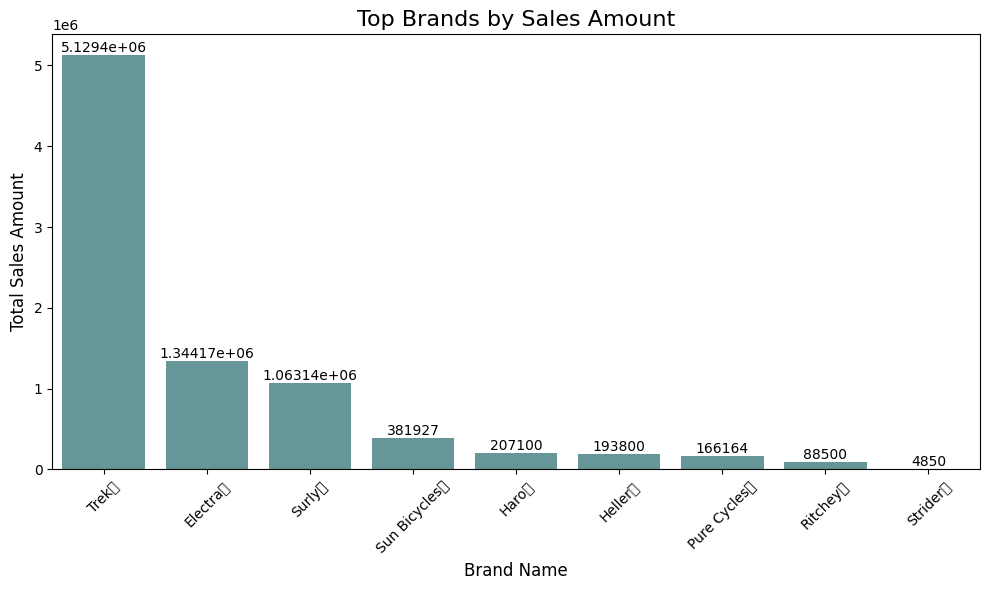

In [12]:
query = """SELECT 
	b.brand_id, b.brand_name,
    SUM(oi.quantity * (oi.list_price - (oi.list_price * oi.discount / 100))) AS total_sales_amount,
    SUM(oi.quantity) AS total_quantity_sold
FROM 
	brands b
JOIN
	products p ON p.brand_id = b.brand_id
JOIN
	order_items oi ON oi.product_id = p.product_id
GROUP BY 
	b.brand_id, b.brand_name
ORDER BY
	total_sales_amount DESC
"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["brand_id", "brand_name","total_sales_amount","total_quantity_sold"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="brand_name", y="total_sales_amount", data=df, color='cadetblue')
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Top Brands by Sales Amount", fontsize=16)
plt.xlabel("Brand Name", fontsize=12)
plt.ylabel("Total Sales Amount", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

## D. What is the average discount provided on each product across all orders?

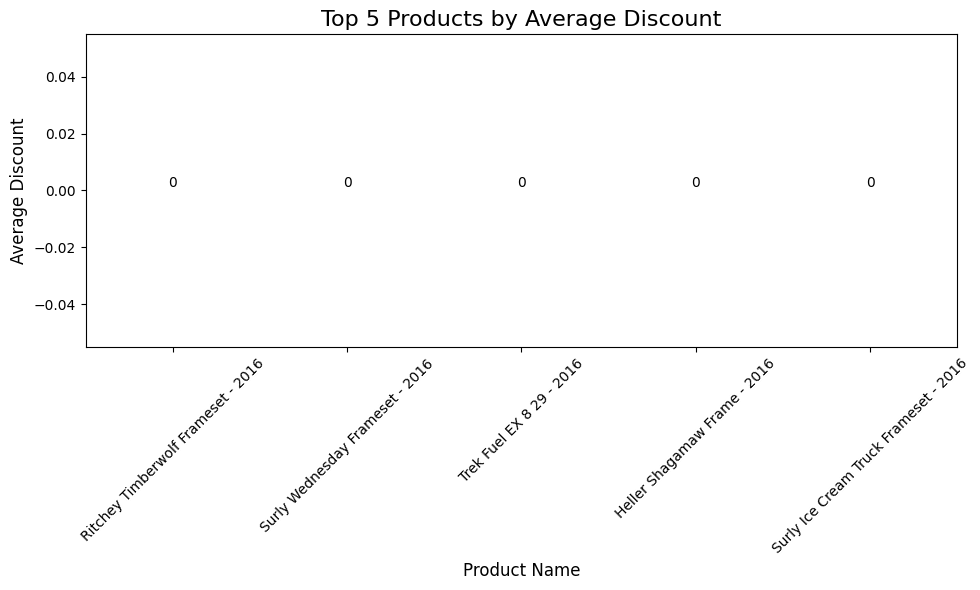

In [13]:
query = """SELECT
	p.product_id, p.product_name, 
    AVG(oi.discount) AS avg_discount
FROM
	products p
LEFT JOIN
	order_items oi ON oi.product_id = p.product_id
GROUP BY
	p.product_id, p.product_name
ORDER BY
	avg_discount DESC
Limit 5
"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["product_id", "product_name","avg_discount"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="product_name", y="avg_discount", data=df, color='deepskyblue')
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Top 5 Products by Average Discount", fontsize=16)
plt.xlabel("Product Name", fontsize=12)
plt.ylabel("Average Discount", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

In [14]:
# The output of the query indicates that there are no Discount on any Products.

# 4. Inventory Management:

## A. Which stores have the highest stock quantities for each product?

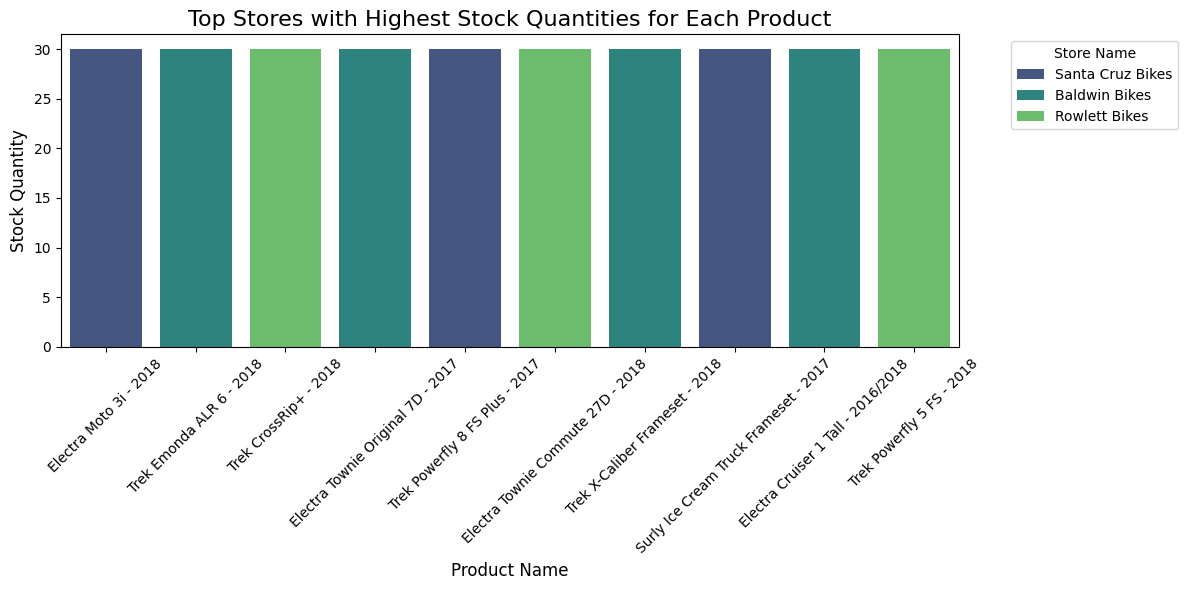

In [15]:
query = """SELECT 
    store_id, store_name, product_id, product_name, stock_quantity
FROM (
    SELECT 
        s.store_id, s.store_name, p.product_id, p.product_name,
        st.quantity AS stock_quantity,
        ROW_NUMBER() OVER (PARTITION BY p.product_id ORDER BY st.quantity DESC) AS row_num
    FROM 
        Stocks st
    JOIN 
        Products p ON st.product_id = p.product_id
    JOIN 
        Stores s ON st.store_id = s.store_id
) subquery
WHERE 
    row_num = 1
ORDER BY 
    stock_quantity DESC
LIMIT 10
"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["store_id", "store_name","product_id","product_name","stock_quantity"])

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='product_name', y='stock_quantity', hue='store_name', palette='viridis')

# Add titles and labels
plt.title('Top Stores with Highest Stock Quantities for Each Product', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Stock Quantity', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Store Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


## B. Which stores have the lowest stock quantities for each product?

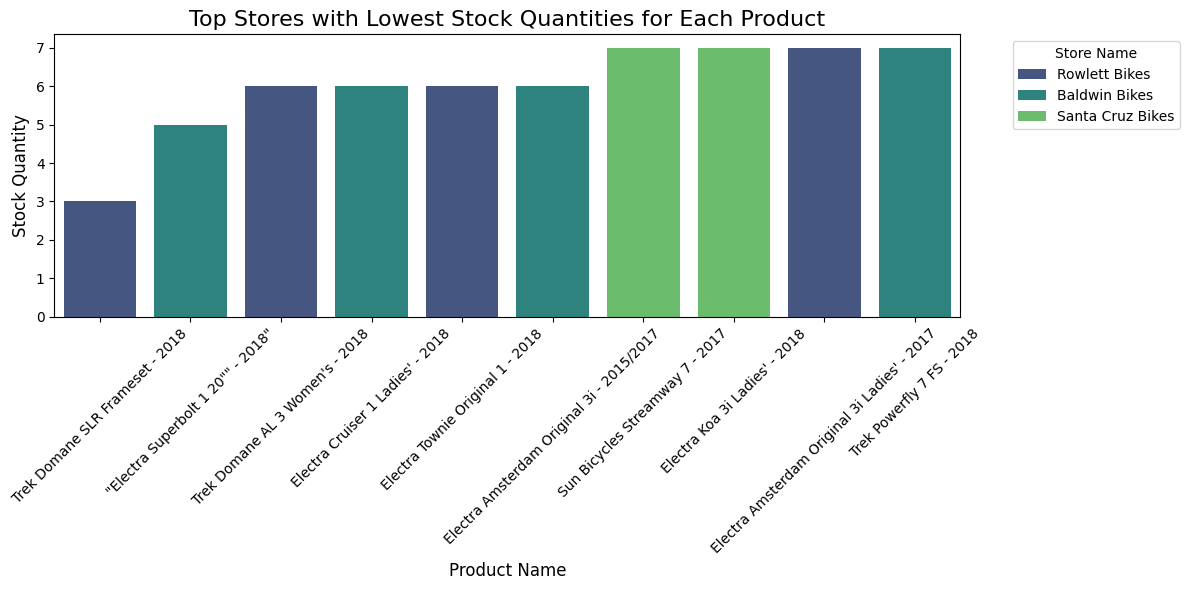

In [16]:
query = """SELECT 
    store_id, store_name, product_id, product_name, stock_quantity
FROM (
    SELECT 
        s.store_id, s.store_name, p.product_id, p.product_name,
        st.quantity AS stock_quantity,
        ROW_NUMBER() OVER (PARTITION BY p.product_id ORDER BY st.quantity DESC) AS row_num
    FROM 
        Stocks st
    JOIN 
        Products p ON st.product_id = p.product_id
    JOIN 
        Stores s ON st.store_id = s.store_id
) subquery
WHERE 
    row_num = 1
ORDER BY 
    stock_quantity
LIMIT 10
"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["store_id", "store_name","product_id","product_name","stock_quantity"])

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='product_name', y='stock_quantity', hue='store_name', palette='viridis')

# Add titles and labels
plt.title('Top Stores with Lowest Stock Quantities for Each Product', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Stock Quantity', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Store Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

## C. What are the products that are low in stock across all stores?

In [17]:
query = """SELECT 
    s.store_id, s.store_name, p.product_id, p.product_name,
    SUM(st.quantity) AS total_stock
FROM 
    Stocks st
JOIN
	stores s ON s.store_id = st.store_id
JOIN 
    Products p ON st.product_id = p.product_id
GROUP BY 
    s.store_id, s.store_name, p.product_id, p.product_name
HAVING 
    total_stock < 3
ORDER BY 
    total_stock ASC

"""

cur.execute(query)

data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["store_id", "store_name","product_id","product_name","stock_quantity"])
df

,store_id,store_name,product_id,product_name,stock_quantity
0,3,Rowlett Bikes,3,Surly Wednesday Frameset - 2016,0
1,1,Santa Cruz Bikes,160,Trek Emonda SLR 6 - 2018,0
2,2,Baldwin Bikes,158,Trek CrossRip 1 - 2018,0
3,1,Santa Cruz Bikes,6,Surly Ice Cream Truck Frameset - 2016,0
4,3,Rowlett Bikes,59,Trek Domane S 5 Disc - 2017,0
...,...,...,...,...,...
92,1,Santa Cruz Bikes,289,"""Electra Superbolt 1 20"""" - 2018""",2
93,1,Santa Cruz Bikes,17,Pure Cycles Vine 8-Speed - 2016,2
94,2,Baldwin Bikes,12,Electra Townie Original 21D - 2016,2
95,2,Baldwin Bikes,312,Electra Townie Commute 8D Ladies' - 2018,2


# 5. Staff and Store Performance:

## A. Which store has the highest number of orders and total revenue?

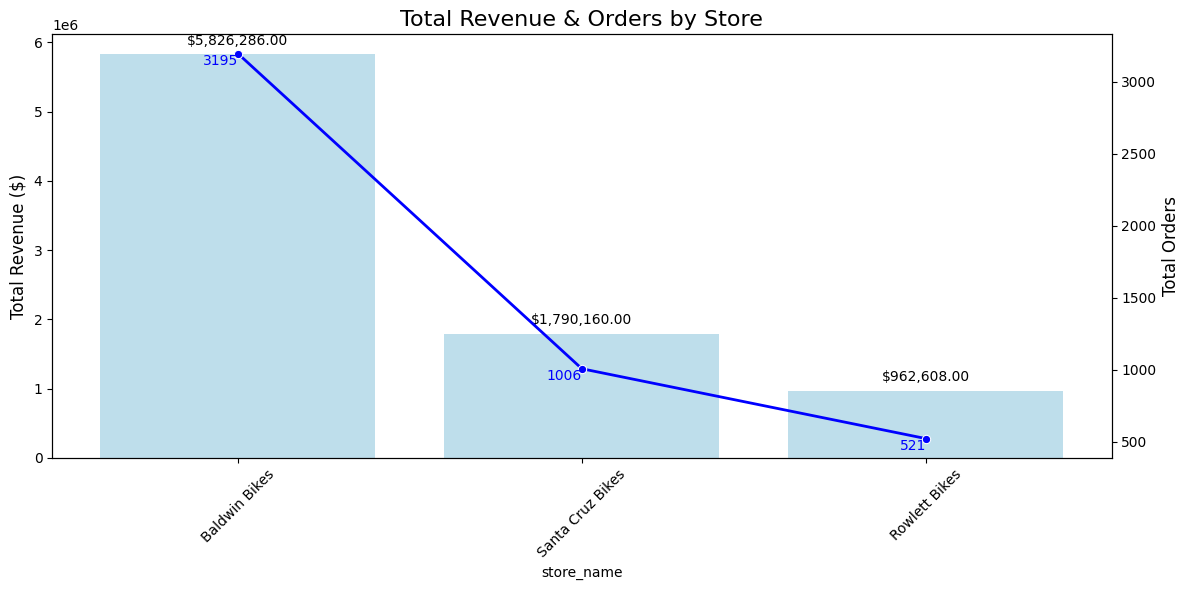

In [18]:
query = """SELECT 
    s.store_id, s.store_name, COUNT(o.order_id) AS total_orders,
    SUM(oi.quantity * (oi.list_price - (oi.list_price * oi.discount / 100))) AS total_revenue
FROM
    stores s
JOIN
    orders o ON o.store_id = s.store_id
JOIN
    order_items oi ON o.order_id = oi.order_id
GROUP BY 
    s.store_id, s.store_name
ORDER BY
    total_orders DESC, total_revenue DESC"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["store_id", "store_name", "total_orders", "total_revenue"])

# Create a bar plot for total revenue
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for total revenue
bar_plot = sns.barplot(data=df, x='store_name', y='total_revenue', ax=ax1, color='skyblue', alpha=0.6)
ax1.set_ylabel('Total Revenue ($)', fontsize=12)
ax1.set_title('Total Revenue & Orders by Store', fontsize=16)
ax1.set_xticklabels(df['store_name'], rotation=45)

# Add data labels to the bars
for p in bar_plot.patches:
    ax1.annotate(f'${p.get_height():,.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', 
                 fontsize=10, color='black', 
                 xytext=(0, 5), 
                 textcoords='offset points')

# Create a second y-axis for total orders
ax2 = ax1.twinx()
line_plot = sns.lineplot(data=df, x='store_name', y='total_orders', ax=ax2, color='b', marker='o', linewidth=2)
ax2.set_ylabel('Total Orders', fontsize=12)

# Add data labels to the line plot below the points
for i, row in df.iterrows():
    ax2.text(i, row['total_orders'] - 2,  # Adjust the y position to be below the point
              row['total_orders'], 
              color='b', ha='right', va='top')  # Change 'va' to 'top' to align the text above the adjusted y position

plt.tight_layout()
plt.show()

## B. What is the total sales generated by each staff member?

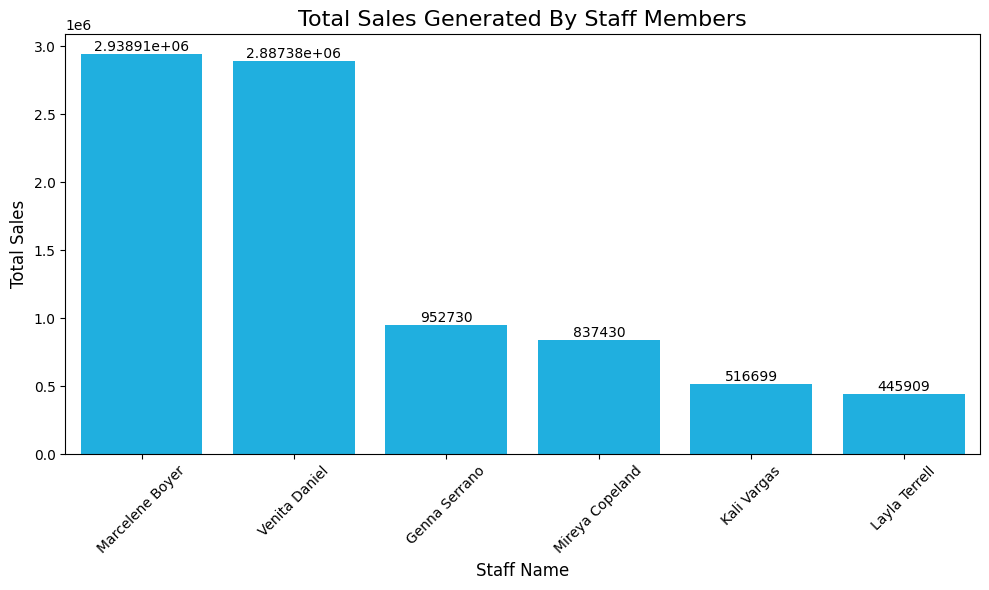

In [19]:
query = """SELECT 
    st.staff_id,
    CONCAT(st.first_name, ' ', st.last_name) AS staff_name,
    SUM(oi.quantity * (oi.list_price - (oi.list_price * oi.discount / 100))) AS total_sales
FROM 
    Orders o
JOIN 
    Order_items oi ON o.order_id = oi.order_id
JOIN 
    Staffs st ON o.staff_id = st.staff_id
GROUP BY 
    st.staff_id, staff_name
ORDER BY 
    total_sales DESC"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["staff_id", "staff_name", "total_sales"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="staff_name", y="total_sales", data=df, color='deepskyblue')
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Total Sales Generated By Staff Members", fontsize=16)
plt.xlabel("Staff Name", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

## C. How does staff performance (sales generated) vary across different stores?

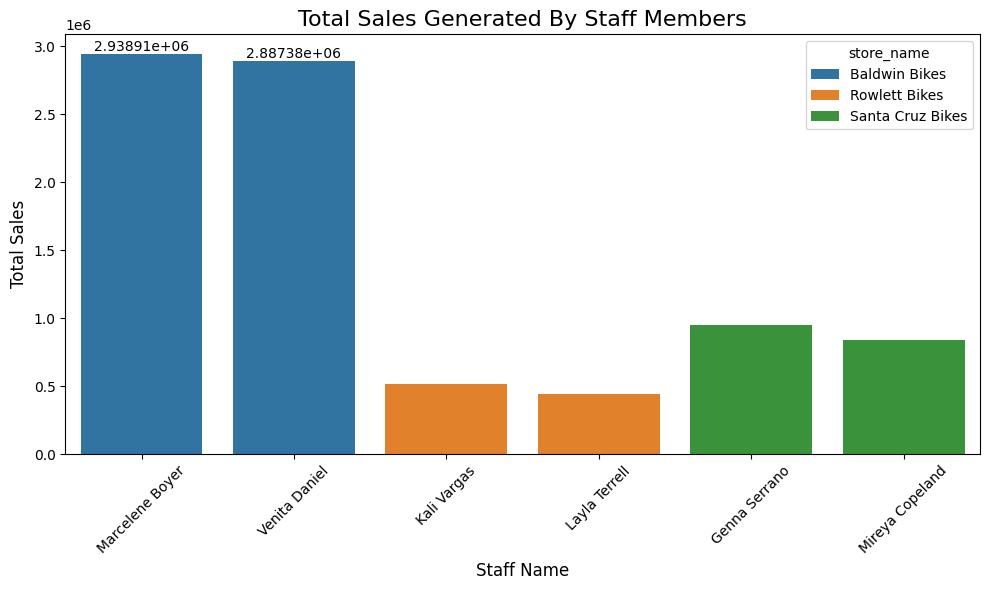

In [20]:
query = """SELECT 
    s.store_id,
    s.store_name,
    st.staff_id,
    CONCAT(st.first_name, ' ', st.last_name) AS staff_name,
    SUM(oi.quantity * (oi.list_price - (oi.list_price * oi.discount / 100))) AS total_sales
FROM 
    Orders o
JOIN 
    Order_items oi ON o.order_id = oi.order_id
JOIN 
    Staffs st ON o.staff_id = st.staff_id
JOIN 
    Stores s ON st.store_id = s.store_id
GROUP BY 
    s.store_id, s.store_name, st.staff_id, staff_name
ORDER BY 
    s.store_name, total_sales DESC"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["store_id","store_name","staff_id", "staff_name", "total_sales"])

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="staff_name", y="total_sales", hue="store_name", data=df)
plt.xticks(rotation=45)

# Adding title and labels
plt.title("Total Sales Generated By Staff Members", fontsize=16)
plt.xlabel("Staff Name", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)

# Adding bar labels
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

# 6. Customer Retention:

## A. How many customers placed more than one order within the last year?

In [21]:
query = """SELECT COUNT(customers_with_multiple_orders) AS customers_with_multiple_orders
FROM (
	SELECT 
		COUNT(DISTINCT customer_id) AS customers_with_multiple_orders
	FROM 
		Orders
	WHERE 
		YEAR(order_date) = 2018 
	GROUP BY 
		customer_id
	HAVING 
		COUNT(order_id) > 1
) sub"""

cur.execute(query)
data = cur.fetchall()

print(f"There are {data[0][0]} Customers with Multiple Orders")

There are 20 Customers with Multiple Orders
